In [426]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz

from SimPEG.utils import plot2Ddata, model_builder
from SimPEG import maps
from SimPEG.potential_fields import gravity

In [427]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

In [428]:

npad=0.
hx = [(1, npad, -1.2), (1, 100), (1, npad, 1.2)]
hy = [ (5, 1)]
hz = [(1, npad, -1.2), (0.5, 140)]
mesh = TensorMesh([hx, hy, hz], "CCN")
mesh_2d = TensorMesh([hx, hz], "CN")

In [429]:
x = np.array([-40,   0,  34, -40, -40,  30,   0, -40, -40])
y = np.array([-10, -10, -30, -64, -62, -30, -12, -12, -10])

In [430]:
gdf_poly = gpd.GeoDataFrame(data={}, geometry=[Polygon(tuple((x[ii], y[ii]) for ii in range(len(x))))])

In [431]:
geoms = gpd.points_from_xy(mesh.cell_centers[:,0], mesh.cell_centers[:,2])
gdf_pts = gpd.GeoDataFrame(data={}, geometry=geoms)

In [432]:
gdf_pts_clip = gdf_pts.clip(gdf_poly)

In [433]:
inds = np.array(list(gdf_pts_clip.index))

In [434]:
inds_active = np.ones(mesh.n_cells, dtype=bool)
inds_active[inds] = False

In [435]:
top_depth = -20
t = 5
w = 5
blk_inds_1 = model_builder.get_indices_block([-20, top_depth-t],[-20+w, top_depth], mesh_2d.cell_centers)

In [436]:
top_depth = -15
t = 5
w = 5
blk_inds_2 = model_builder.get_indices_block([-20, top_depth-t],[-20+w, top_depth], mesh_2d.cell_centers)

In [455]:
top_depth = -13
t = 5
w = 5
blk_inds_3 = model_builder.get_indices_block([-20, top_depth-t],[-20+w, top_depth], mesh_2d.cell_centers)

In [456]:
rho1 = np.ones(mesh.n_cells) * 2.1
rho1[~inds_active] = 0
rho_background = rho1.copy()
rho1[blk_inds_1] = 0

In [457]:
rho2 = np.ones(mesh.n_cells) * 2.1
rho2[~inds_active] = 0.
rho2[blk_inds_2] = 0.

In [465]:
rho3 = np.ones(mesh.n_cells) * 2.1
rho3[~inds_active] = 0.
rho3[blk_inds_3] = 0.

In [458]:
from shapely import Polygon

In [459]:
n_rec1 = 10
x_rec_1 = -38 + np.arange(n_rec1) * 4
y_rec_1 = np.ones(n_rec1) * -11

# d = np.sqrt(34**2+30**2)
# print (d)
n_rec2 = 10
theta_2 = np.rad2deg(np.arctan2(20,34))
d = np.arange(n_rec2) * 4 + 1
x_rec_2 = d * np.cos(np.deg2rad(theta_2))
y_rec_2 = -d * np.sin(np.deg2rad(theta_2)) - 11.

n_rec2 = 19
theta_3 = np.rad2deg(np.arctan2(32,70))
d = np.arange(n_rec2) * 4 + 4
x_rec_3 = -d * np.cos(np.deg2rad(theta_3))+32
y_rec_3 = -d * np.sin(np.deg2rad(theta_3)) - 30.


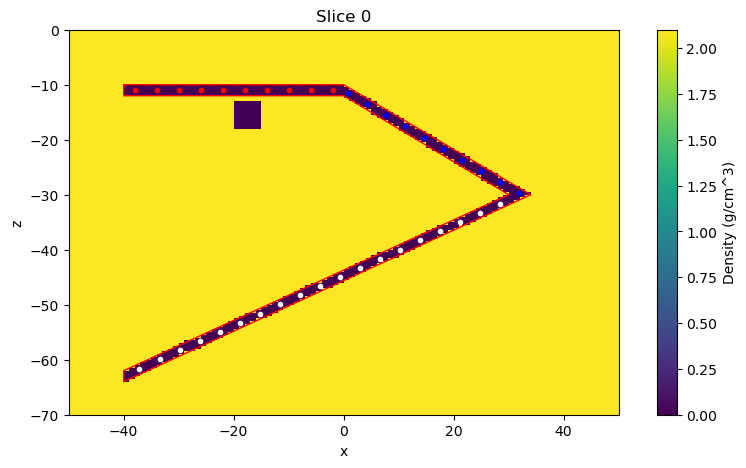

In [469]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
out = mesh.plot_slice(
    rho3, grid=False, normal='Y', ax=ax, 
#     grid_opts={'color':'k', 'lw':0.01}
)
plt.plot(x, y, 'r-', lw=1)
plt.plot(x_rec_1, y_rec_1, 'r.', lw=1)
plt.plot(x_rec_2, y_rec_2, 'b.', lw=1)
plt.plot(x_rec_3, y_rec_3, 'w.', lw=1)
plt.plot()
ax.set_aspect(1)
cb = plt.colorbar(out[0])
cb.set_label("Density (g/cm^3)")

In [461]:
x_rec = np.r_[x_rec_1, x_rec_2, x_rec_3]
y_rec = np.zeros_like(x_rec)
z_rec = np.r_[y_rec_1, y_rec_2, y_rec_3]
receiver_locations = np.c_[x_rec, y_rec, z_rec]

In [462]:
len(receiver_locations)

39

In [463]:
components = ["gz"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Defining the source field.
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Defining the survey
survey = gravity.survey.Survey(source_field)

In [466]:
# nC = int(inds_active.sum())
model_map = maps.IdentityMap(nP=mesh.n_cells)

# Define the forward simulation. By setting the 'store_sensitivities' keyword
# argument to "forward_only", we simulate the data without storing the sensitivities
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=model_map,
#     ind_active=inds_active,
    store_sensitivities="forward_only",
)

# Compute predicted data for some model
# SimPEG uses right handed coordinate where Z is positive upward.
# This causes gravity signals look "inconsistent" with density values in visualization.
dpred1 = simulation.dpred(rho1)
dpred2 = simulation.dpred(rho2)
dpred3 = simulation.dpred(rho3)
dpred_background = simulation.dpred(rho_background)

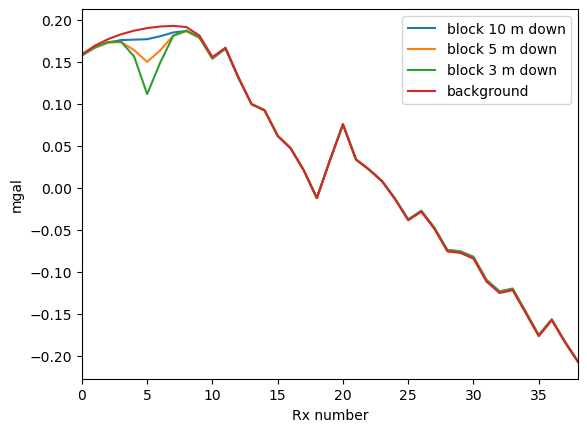

In [467]:
plt.plot(-dpred1, label='block 10 m down')
plt.plot(-dpred2, label='block 5 m down')
plt.plot(-dpred3, label='block 3 m down')
plt.plot(-dpred_background, label='background')
plt.legend()
plt.ylabel("mgal")
plt.xlim(0, 38)
plt.xlabel("Rx number")
plt.legend()

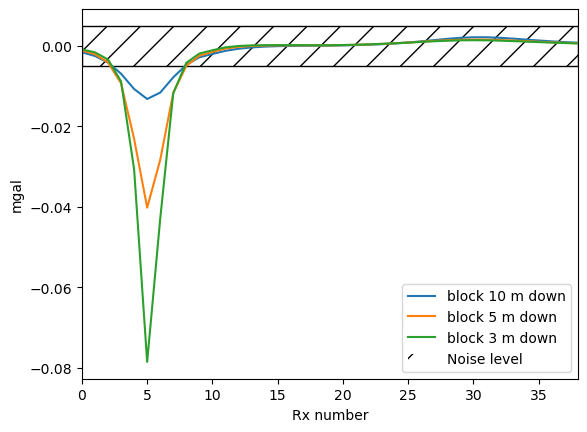

In [468]:
# plt.plot(dpred)
plt.plot(-(dpred1-dpred_background), label='block 10 m down')
plt.plot(-(dpred2-dpred_background), label='block 5 m down')
plt.plot(-(dpred3-dpred_background), label='block 3 m down')
plt.fill_between((0, 38), -0.005, 0.005, hatch='/', facecolor='None', label='Noise level')
plt.xlim(0, 38)
plt.xlabel("Rx number")
plt.ylabel("mgal")
plt.legend()